# Prédiction des consommations

## Importation librairies et données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
%matplotlib inline

sns.set(font_scale=1.8)


from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,explained_variance_score

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from time import time
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import shap
shap.initjs()

In [2]:
data = pd.read_csv('data.csv').drop(columns=['TotalGHGEmissions'])


## Standardisation des variables avec le Standard Scaler

In [3]:
scaler= StandardScaler()
features = data.drop(columns='SiteEnergyUseWN(kBtu)').columns

X = data.drop(columns='SiteEnergyUseWN(kBtu)')
X = pd.DataFrame(scaler.fit_transform(X),columns=features)

y = data['SiteEnergyUseWN(kBtu)']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


## Première prédiction des données de test avec 11 modèles

In [4]:
regressors = [
    ["Dummy",DummyRegressor()],
    ['linear', LinearRegression()],
    ['lasso',Lasso()],
    ['ridge',Ridge()],
    ['elasticnet',ElasticNet()],
    ['KNN',KNeighborsRegressor()],
    ['decisiontree',DecisionTreeRegressor()],
    ['extratree',ExtraTreesRegressor()],
    ['randomforest',RandomForestRegressor()],
    ['Gradient',GradientBoostingRegressor()],
    ['xgboost',XGBRegressor()]
]



In [5]:
pd.options.display.float_format = '{:20,.2f}'.format

y.describe()


count               1,455.00
mean            6,956,801.48
std            11,096,052.79
min                     0.00
25%             1,299,341.38
50%             2,789,899.00
75%             7,442,881.50
max            92,537,256.00
Name: SiteEnergyUseWN(kBtu), dtype: float64

In [6]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressor_name'] = [item[0] for item in regressors] 
results['regressors'] = [item[1] for item in regressors] 


    
for model in [item[1] for item in regressors]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.loc[results['regressors']==model,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==model,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==model,'R2_score'] = r2_score(y_test, y_pred)

results

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+16, tolerance: 1.434e+13


,regressor_name,regressors,RMSE,MAE,R2_score
0,Dummy,DummyRegressor(),"11,060,394.00","6,776,205.99",-0.00
1,linear,LinearRegression(),"270,526,587,152,493,477,888.00","27,873,228,005,835,051,008.00","-598,467,913,075,314,402,516,795,392.00"
2,lasso,Lasso(),"8,257,967.41","3,828,546.39",0.44
3,ridge,Ridge(),"6,845,753.44","3,642,296.87",0.62
4,elasticnet,ElasticNet(),"6,486,526.70","3,592,633.44",0.66
5,KNN,KNeighborsRegressor(),"8,977,909.39","4,564,676.25",0.34
6,decisiontree,DecisionTreeRegressor(),"6,407,699.60","3,195,643.19",0.66
7,extratree,"(ExtraTreeRegressor(random_state=1694681818), ...","5,437,790.49","2,562,313.48",0.76
8,randomforest,"(DecisionTreeRegressor(max_features='auto', ra...","5,171,593.00","2,488,687.31",0.78
9,Gradient,([DecisionTreeRegressor(criterion='friedman_ms...,"5,054,684.60","2,514,945.05",0.79


In [7]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns=[item[0] for item in regressors])

for model,name in zip([item[1] for item in regressors],[item[0] for item in regressors]):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e+16, tolerance: 1.576e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+16, tolerance: 1.705e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+16, tolerance: 1.595e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e+16, tolerance: 1.519e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+16, tolerance: 1.667e+13
Objective did n

,Dummy,linear,lasso,ridge,elasticnet,KNN,decisiontree,extratree,randomforest,Gradient,xgboost
0,-0.00,"-260,187,234,349,705,376,322,027,520.00",0.70,0.64,0.54,0.41,0.47,0.83,0.69,0.66,0.79
1,-0.01,"-1,967,053,031,510,836,055,403,134,976.00",0.53,0.45,0.68,0.25,0.49,0.76,0.61,0.74,0.81
2,-0.00,"-2,133,610,176,398,109,873,054,679,040.00",0.52,0.72,0.57,0.34,0.47,0.75,0.75,0.72,0.47
3,-0.00,"-211,883,077,830,992,145,338,597,376.00",0.79,0.82,0.58,0.44,0.56,0.77,0.84,0.73,0.68
4,-0.00,"-3,674,714,557,635,503,312,433,315,840.00",0.23,0.68,0.71,0.33,0.60,0.83,0.67,0.77,0.61
5,-0.00,"-792,569,604,846,031,089,631,756,288.00",0.54,0.23,0.68,0.53,0.65,0.51,0.74,0.68,0.68
6,-0.01,"-988,030,473,189,357,782,032,187,392.00",0.64,0.52,0.63,0.21,0.71,0.61,0.81,0.79,0.72
7,-0.00,"-258,103,318,212,576,370,803,867,648.00",0.58,0.48,0.44,0.38,0.63,0.73,0.64,0.62,0.57
8,-0.00,"-1,578,330,193,421,209,415,876,345,856.00",0.45,0.65,0.50,-0.01,0.24,0.83,0.78,0.83,0.79
9,-0.03,"-104,509,665,422,453,039,624,617,984.00",0.29,0.62,0.82,0.60,0.56,0.82,0.67,0.65,0.78


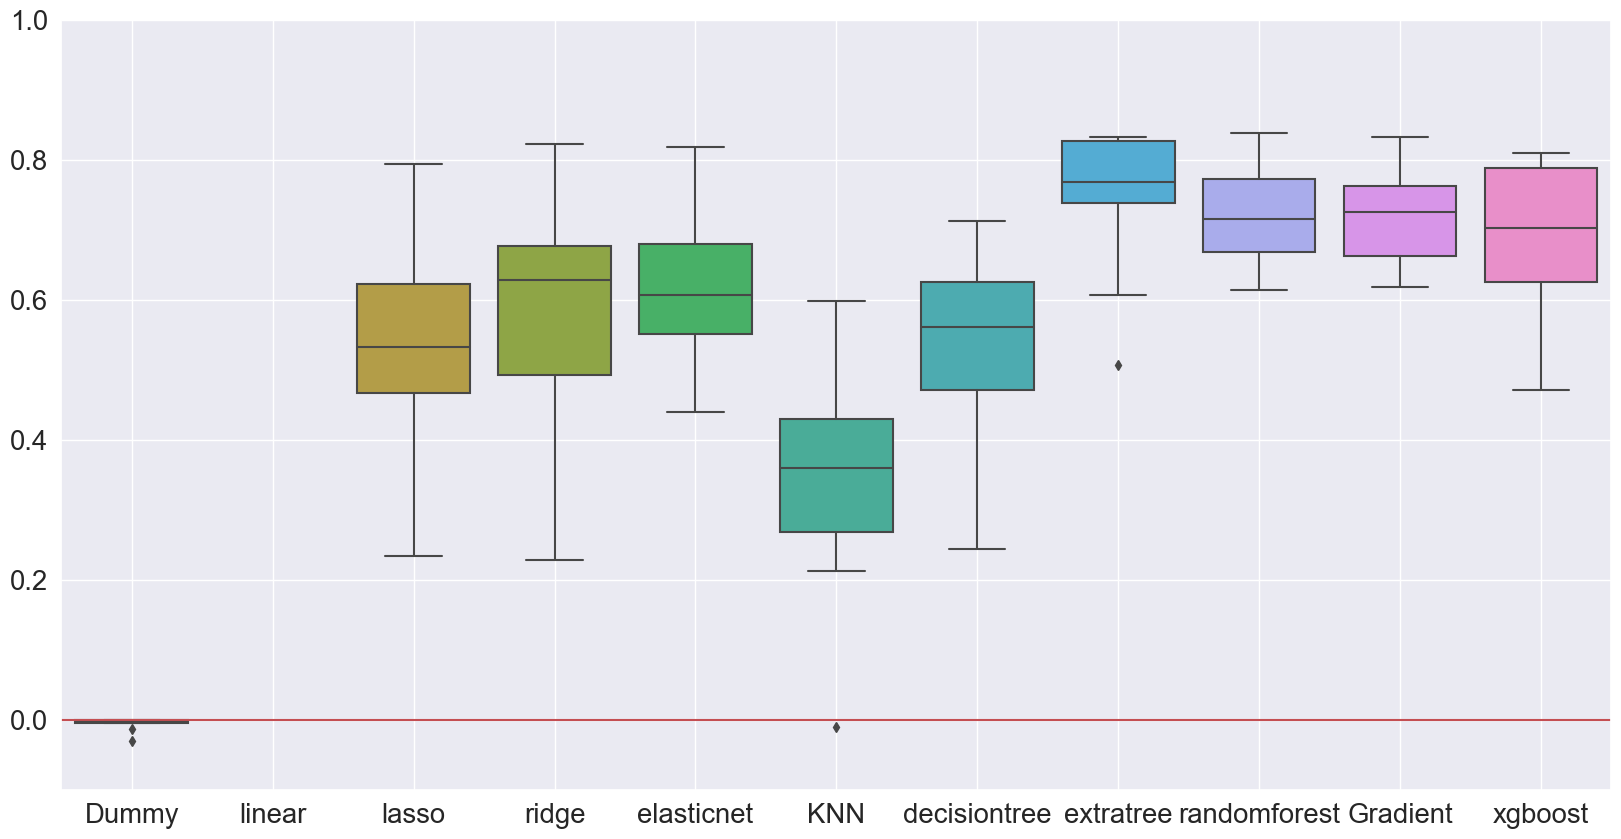

In [8]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-0.1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)



### On constate que les modèles les plus performants sont le Gradient Boosting Regressor, l'extratrees, le linear, le lasso, le ridge, le Xboost et le RandomForest.

# GridSearch sur les meilleurs modèles

In [9]:
# set_models and params 

models = [
    [ElasticNet(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "l1_ratio" : [0.2,0.5,0.8],
    "random_state" :  [133]
}],
    [Ridge(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "random_state" :  [133]
}],
    [Lasso(), {
    "alpha" : [1,2,3,4,5,6,7,8,9,10],
    "random_state" :  [133]
}],
    [RandomForestRegressor(), {
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "max_features" : [None, 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [GradientBoostingRegressor(), {
    "learning_rate" : [0.01,0.05,0.1],
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "max_features" : ['auto', 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [ExtraTreesRegressor(), {
    "max_depth" : [4,5,6],
    "max_features" : ['auto', 'sqrt', 'log2'],
    "random_state" :  [133]
}],
    [XGBRegressor(), {
    "n_estimators" : [50,100,200,400],
    "max_depth" : [4,5,6],
    "gamma" : [0.01,0.1],
    "learning_rate" : [0.01,0.05,0.1],
    "random_state" :  [133]
}]
]


In [10]:
good_regressors = []
for model in models : 
    
    GS = GridSearchCV(estimator = model[0],
                 param_grid = model[1],
                 scoring = ['r2','neg_root_mean_squared_error'],
                 refit='r2',
                 cv=10)
    
    GS.fit(X_train,y_train)
    
    print(model[0])
    print(GS.best_params_)
    print(GS.best_score_)
    print('\t')
    
    good_regressors.append(GS.best_estimator_)

ElasticNet()
{'alpha': 1, 'l1_ratio': 0.8, 'random_state': 133}
0.6540497942975783
	
Ridge()
{'alpha': 10, 'random_state': 133}
0.612741564173282
	


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e+16, tolerance: 1.312e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+16, tolerance: 1.337e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e+16, tolerance: 1.356e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e+16, tolerance: 1.296e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e+16, tolerance: 1.294e+13
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e+16, tolerance: 1.296e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e+16, tolerance: 1.294e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+16, tolerance: 1.256e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e+16, tolerance: 1.258e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e+16, tolerance: 1.324e+13
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e+16, tolerance: 1.258e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+16, tolerance: 1.324e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e+16, tolerance: 1.280e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+16, tolerance: 1.194e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+16, tolerance: 1.312e+13
Objective did n

Lasso()
{'alpha': 10, 'random_state': 133}
0.42688268415882835
	
RandomForestRegressor()
{'max_depth': 6, 'max_features': None, 'n_estimators': 400, 'random_state': 133}
0.6818929916964465
	
GradientBoostingRegressor()
{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 400, 'random_state': 133}
0.7490017110686091
	
ExtraTreesRegressor()
{'max_depth': 6, 'max_features': 'auto', 'random_state': 133}
0.6577282621606456
	
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
     

In [11]:
good_regressors_name=['elastic','ridge','lasso','randomforest','gradient','extratree','xgboost']

In [12]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns= good_regressors_name)

for model,name in zip(good_regressors,good_regressors_name):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e+16, tolerance: 1.611e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e+16, tolerance: 1.567e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e+16, tolerance: 1.595e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e+16, tolerance: 1.654e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e+16, tolerance: 1.642e+13
Objective did n

,elastic,ridge,lasso,randomforest,gradient,extratree,xgboost
0,0.65,0.68,0.64,0.80,0.82,0.68,0.72
1,0.66,0.74,0.53,0.73,0.76,0.68,0.46
2,0.58,0.52,0.65,0.72,0.75,0.83,0.79
3,0.68,0.68,0.58,0.47,0.70,0.80,0.78
4,0.58,0.60,0.48,0.83,0.66,0.68,0.55
5,0.79,0.60,0.37,0.48,0.76,0.70,0.83
6,0.64,0.57,0.11,0.79,0.76,0.57,0.75
7,0.70,0.81,0.61,0.69,0.79,0.45,0.76
8,0.69,0.58,0.77,0.54,0.77,0.63,0.71
9,0.80,0.57,0.53,0.57,0.74,0.81,0.74


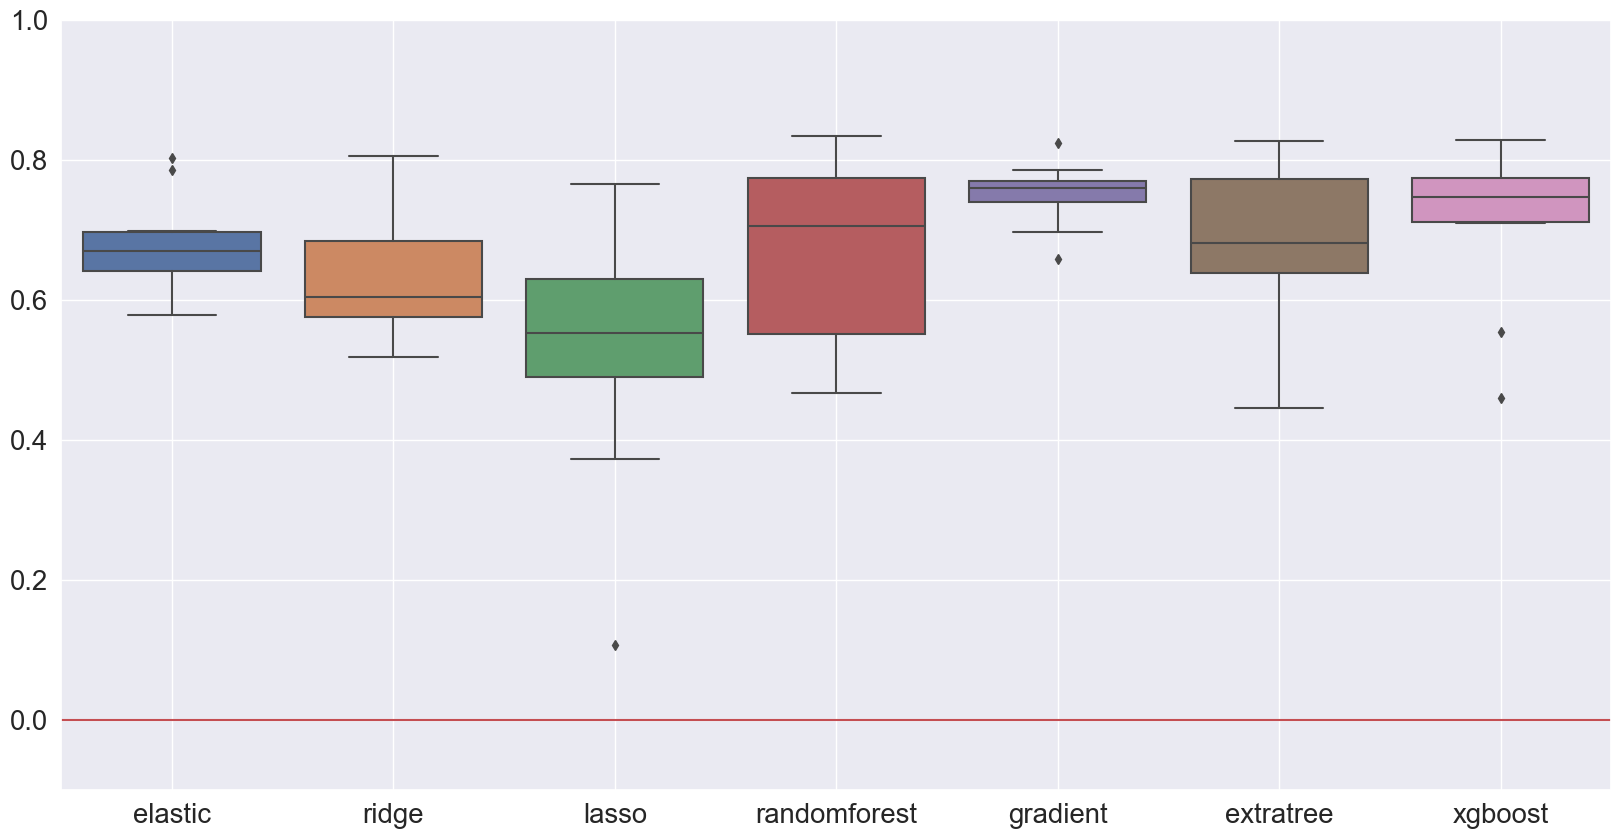

In [13]:

plt.figure(figsize=[20,10])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-0.1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)



In [14]:
kf = KFold(n_splits=10,shuffle=True)
j=0
df=pd.DataFrame(columns= good_regressors_name)

X_copy=X.drop(columns='ENERGYSTARScore')

for model,name in zip(good_regressors,good_regressors_name):
    score =[]

    for i, (train_index, test_index) in enumerate(kf.split(X)):
        train_X, train_y = X_copy.iloc[train_index],y.iloc[train_index]
        valid_X, valid_y = X_copy.iloc[test_index],y.iloc[test_index]
        model.fit(train_X,train_y)
        y_pred = model.predict(valid_X)
        score.append(r2_score(valid_y, y_pred))
    
    df.iloc[:,j]=score
    j=j+1
    
df

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e+16, tolerance: 1.627e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e+16, tolerance: 1.652e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e+16, tolerance: 1.634e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e+16, tolerance: 1.592e+13
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e+16, tolerance: 1.547e+13
Objective did n

,elastic,ridge,lasso,randomforest,gradient,extratree,xgboost
0,0.70,0.61,0.61,0.69,0.72,0.66,0.61
1,0.69,0.60,0.51,0.71,0.71,0.76,0.25
2,0.62,0.66,0.50,0.76,0.69,0.49,0.79
3,0.57,0.53,0.71,0.66,0.74,0.57,0.82
4,0.60,0.67,0.50,0.47,0.74,0.55,0.80
5,0.68,0.55,0.57,0.72,0.81,0.69,0.62
6,0.59,0.43,0.56,0.58,0.57,0.66,0.69
7,0.69,0.68,-0.68,0.72,0.78,0.69,0.78
8,0.69,0.68,0.80,0.62,0.78,0.81,0.83
9,0.79,0.68,0.61,0.80,0.73,0.69,0.73


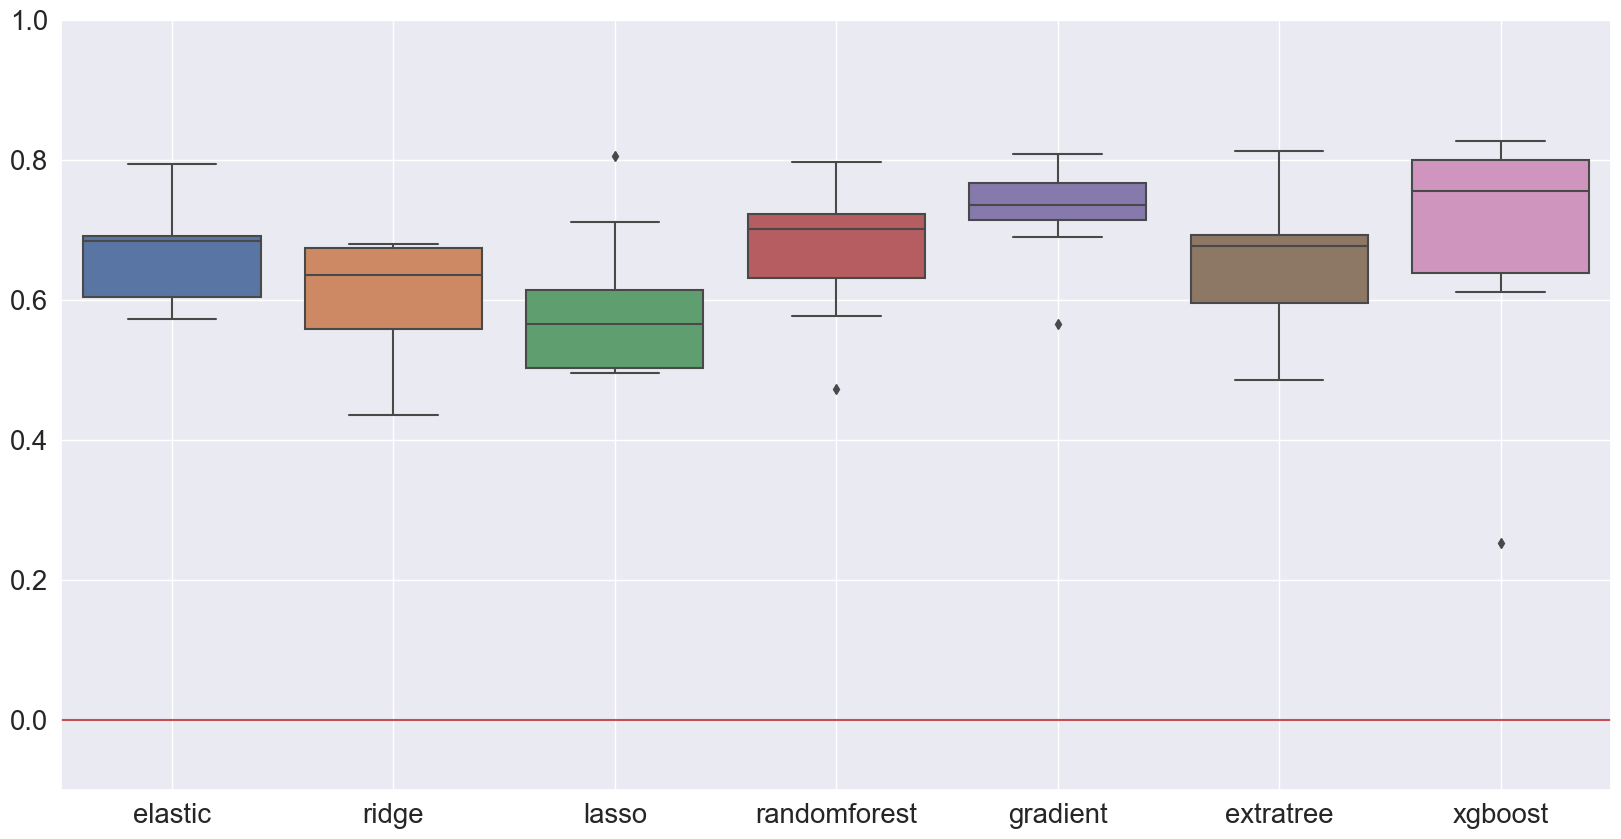

In [15]:
plt.figure(figsize=[20,10])
sns.boxplot(data=df)
ax = plt.gca()
ax.set_ylim([-0.1, 1])
plt.axhline(y=0, color='r', linestyle='-')
ax.grid(True)


## Validation des bons régresseurs sur les données de test : comparaison avec ou sans EnergyStarScore

In [16]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressors'] = good_regressors_name 

X_train_copy = X_train.drop(columns='ENERGYSTARScore')
X_test_copy = X_test.drop(columns='ENERGYSTARScore')

for model,name in zip(good_regressors,good_regressors_name):
        model.fit(X_train_copy, y_train)
        y_pred = model.predict(X_test_copy)
        results.loc[results['regressors']==name,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==name,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==name,'R2_score'] = r2_score(y_test, y_pred)
results.sort_values(ascending=False,by="R2_score")

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+16, tolerance: 1.434e+13


,regressors,RMSE,MAE,R2_score
6,xgboost,"5,605,137.67","2,836,385.87",0.74
4,gradient,"5,606,481.55","2,839,286.09",0.74
3,randomforest,"5,613,879.26","2,999,062.35",0.74
5,extratree,"5,775,818.27","3,327,516.81",0.73
1,ridge,"6,215,682.73","3,548,579.46",0.68
0,elastic,"6,255,196.01","3,564,724.44",0.68
2,lasso,"8,231,055.85","3,970,448.69",0.45


In [17]:
results = pd.DataFrame()
pd.options.display.float_format = '{:20,.2f}'.format

results['regressors'] = good_regressors_name 

for model,name in zip(good_regressors,good_regressors_name):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.loc[results['regressors']==name,"RMSE"] =  np.sqrt(mean_squared_error(y_test, y_pred))        
        results.loc[results['regressors']==name,"MAE"] =  mean_absolute_error(y_test, y_pred)
        results.loc[results['regressors']==name,'R2_score'] = r2_score(y_test, y_pred)
results.sort_values(ascending=False,by="R2_score")

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e+16, tolerance: 1.434e+13


,regressors,RMSE,MAE,R2_score
4,gradient,"5,130,210.35","2,452,872.38",0.78
6,xgboost,"5,184,567.02","2,508,384.11",0.78
3,randomforest,"5,414,886.36","2,830,722.42",0.76
5,extratree,"5,823,932.62","3,310,151.43",0.72
1,ridge,"5,986,952.48","3,372,005.30",0.71
0,elastic,"6,078,253.47","3,405,804.05",0.70
2,lasso,"8,242,844.46","3,827,308.33",0.44


## Etude feature importance

In [20]:
model = good_regressors[4]

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
expected_values = explainer.expected_value


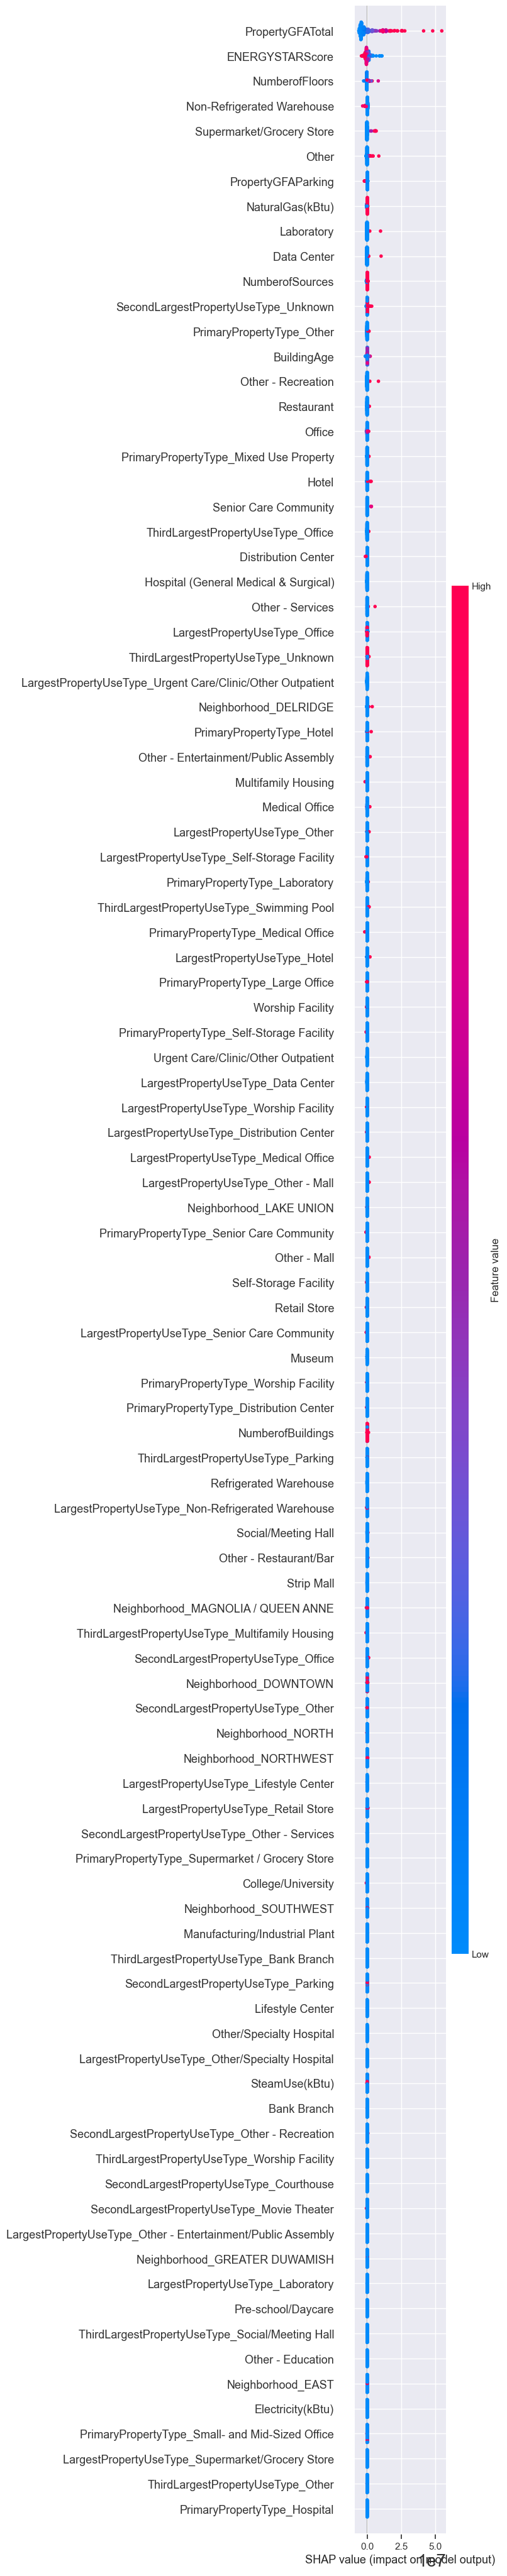

In [21]:
shap.summary_plot(shap_values,features = X_test,max_display=100)


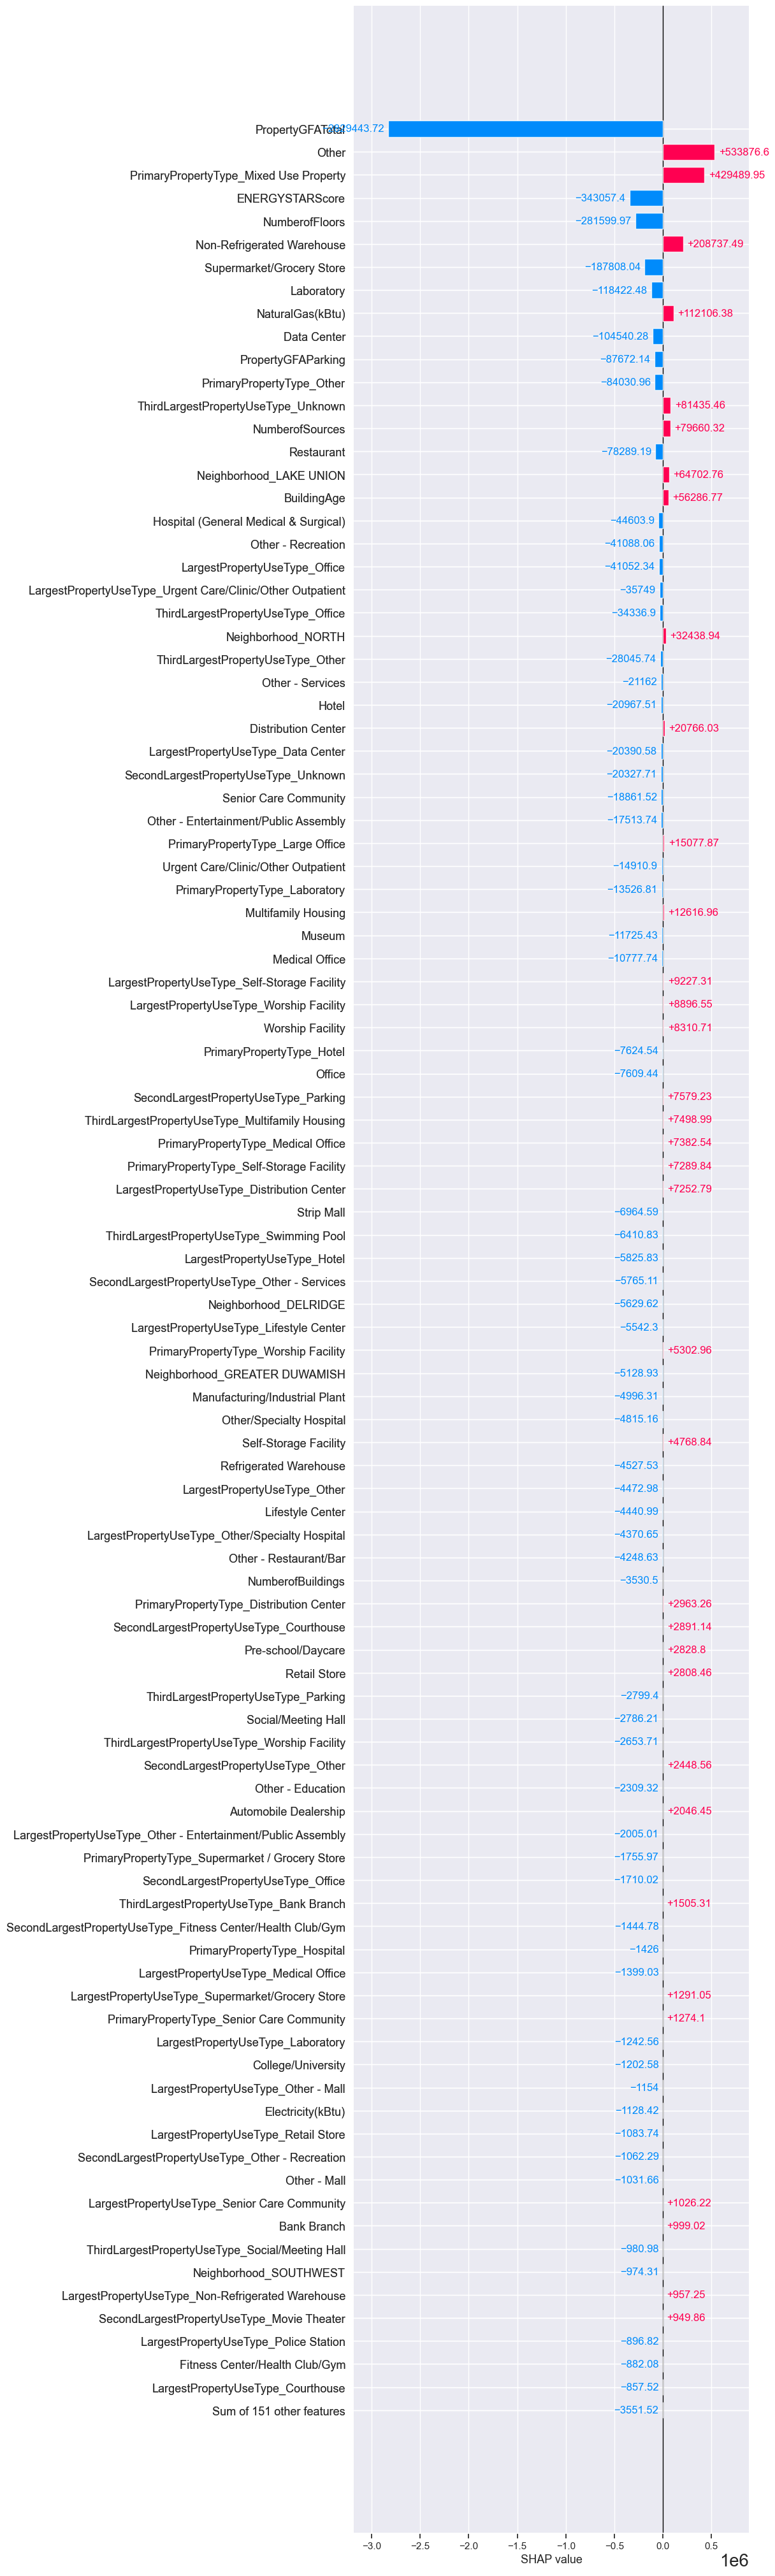

In [22]:
shap.plots.bar(explainer(X_test)[1],max_display=100)


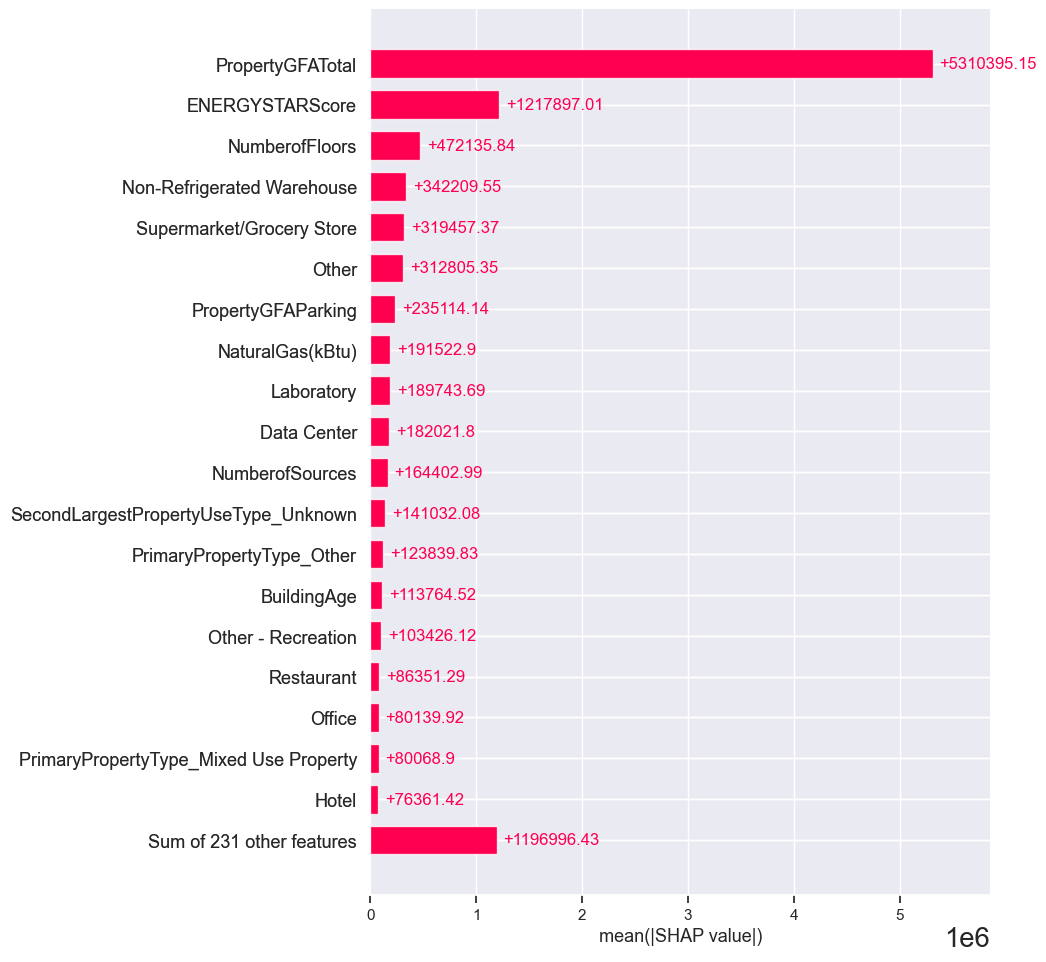

In [23]:
shap.plots.bar(explainer(X_test),max_display=20)


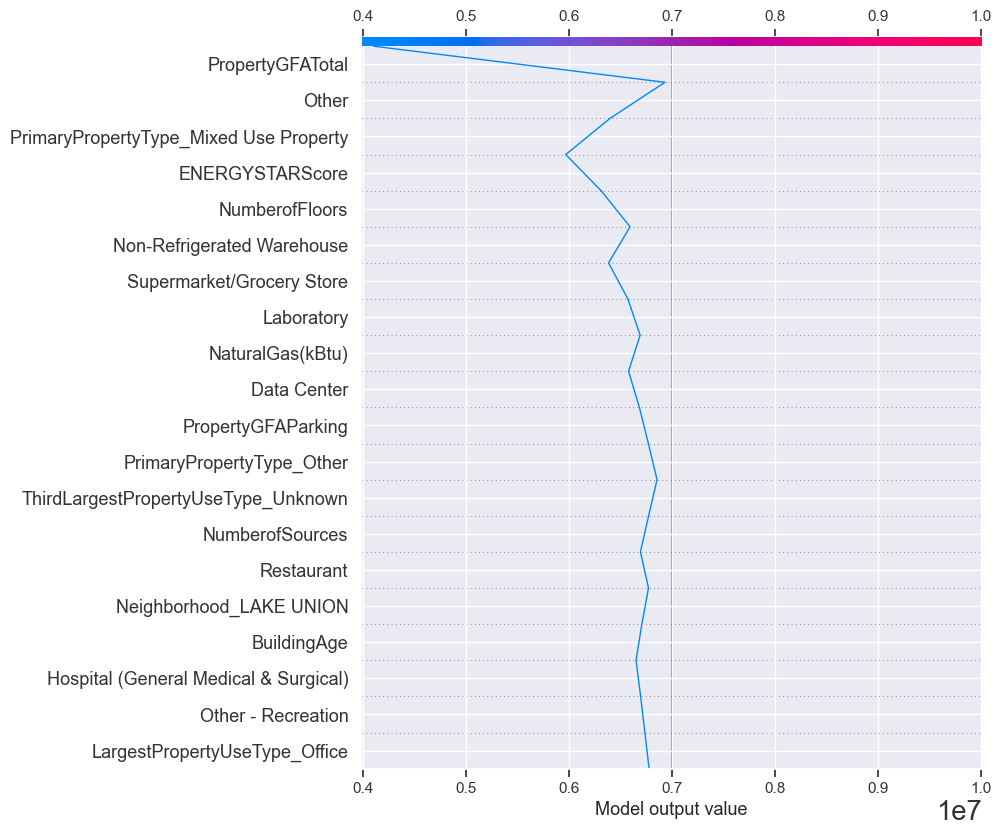

In [24]:
shap.plots.decision(expected_values,shap_values[1],X_train.columns)


<AxesSubplot:title={'center':"GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='auto',\n                          n_estimators=400, random_state=133)"}>

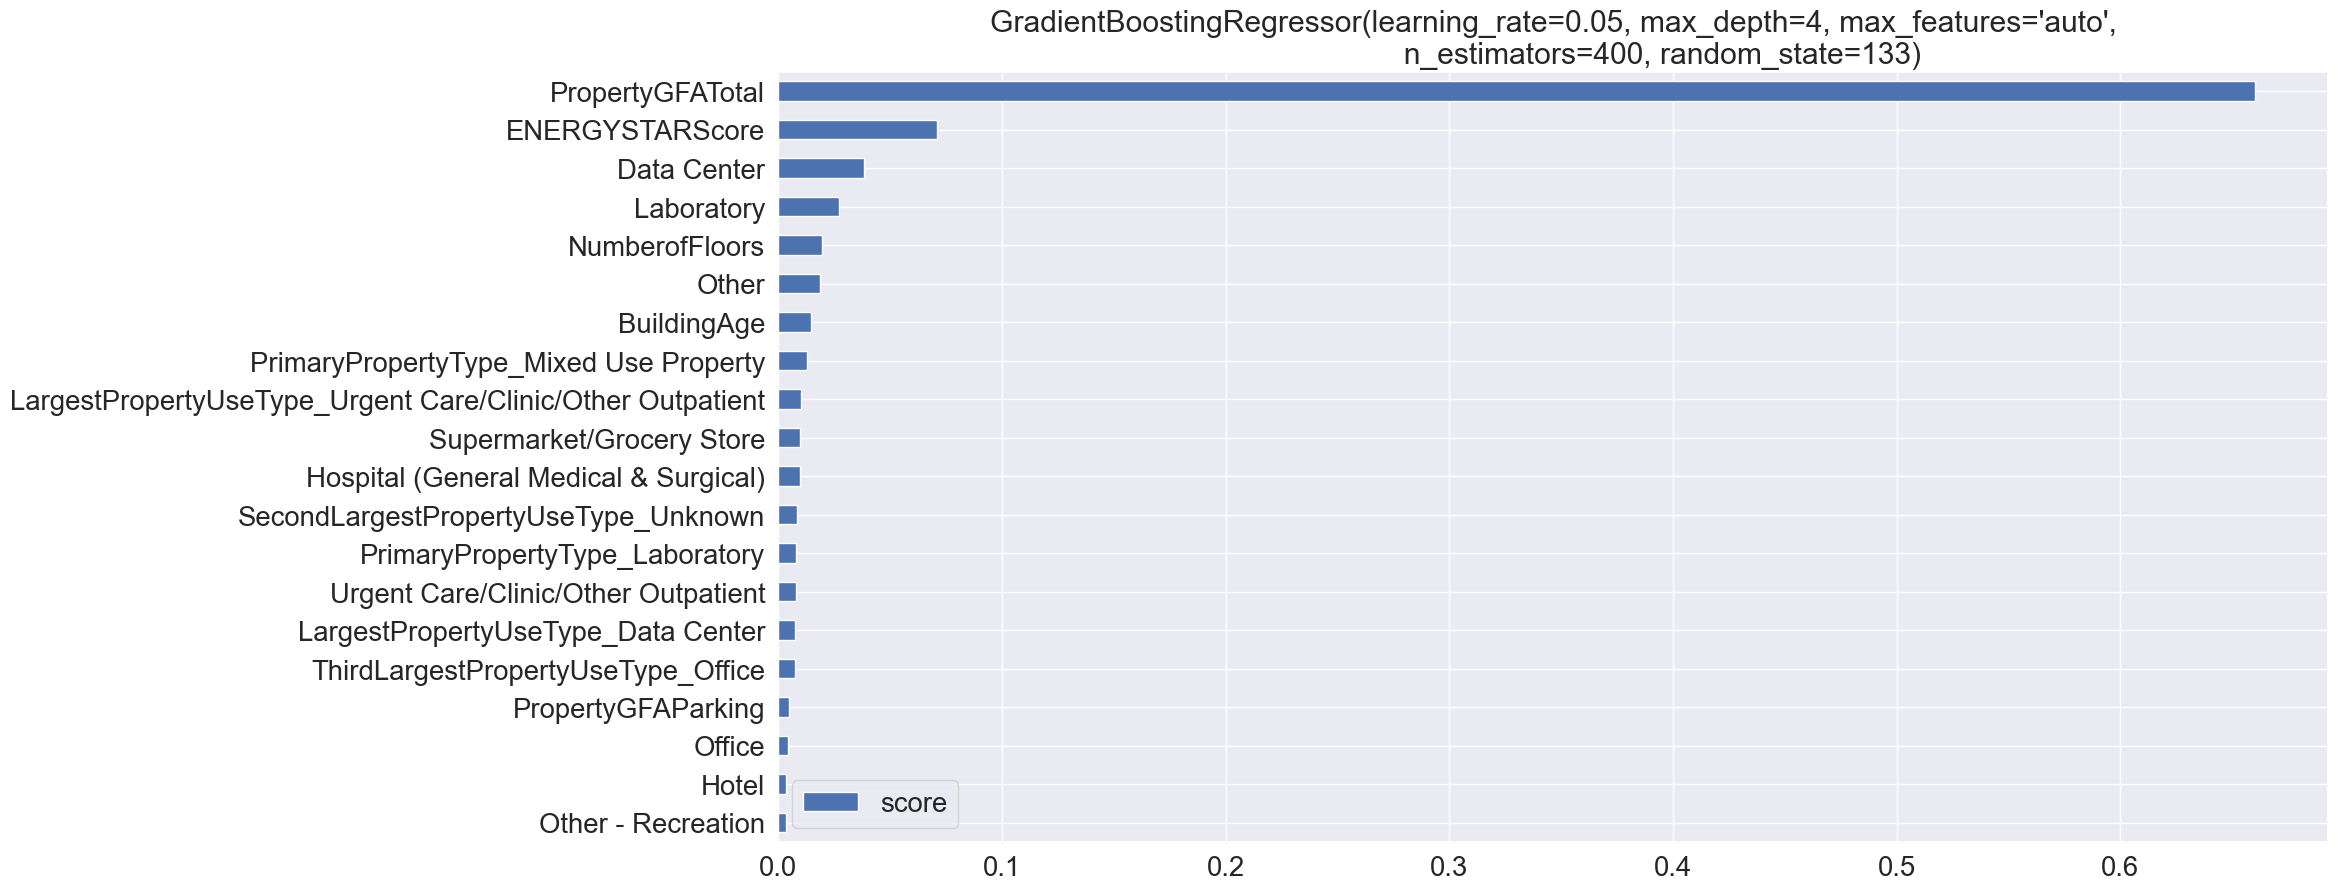

In [26]:

keys = model.feature_names_in_
values = model.feature_importances_
features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
features.nlargest(20, columns="score").sort_values(by = "score", ascending=True).plot(kind='barh', figsize = (20,10),title = str(model))
